# Optimization Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate how to determine the optimal number of components for a `YPlusModel` model.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_yplus
print("bayes_yplus version:", bayes_yplus.__version__)

from bayes_yplus import YPlusModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.5.0+6.g3c38c15
bayes_yplus version: 1.0.0+2.g167b914.dirty


## Simulating Data

Text(0, 0.5, 'Brightness Temperature (mK)')

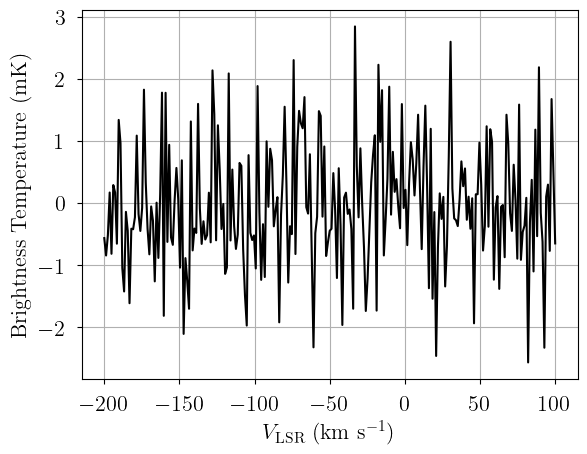

In [2]:
from bayes_spec import SpecData

# spectral axis definition
spec_axis = np.linspace(-200.0, 100.0, 251) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # mK

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(spec_axis)) # mK

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    spec_axis,
    brightness_data,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Text(0, 0.5, 'Brightness Temperature (mK)')

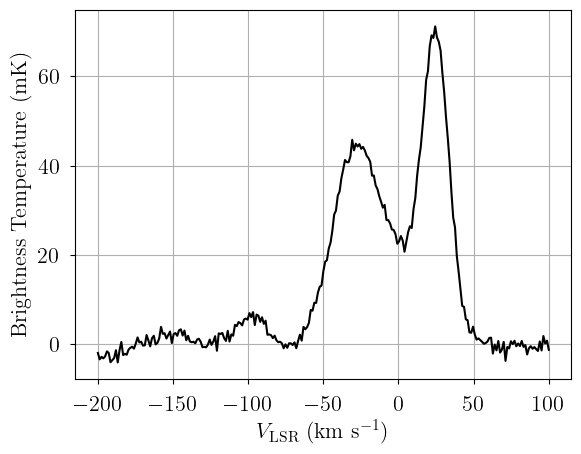

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = YPlusModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized baseline coefficients
    ordered = False, # do not assume ordered velocities
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "H_area": [1500.0, 1000.0, 1250.0],
    "H_center": [-30.0, 5.0, 25.0],
    "H_fwhm": [35.0, 50.0, 20.0],
    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],
    "yplus": [0.1, 0.05, 0.15],
    "rms_observation": noise,
    "observation_baseline_norm": [-1.0, 2.0, -2.5], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    spec_axis,
    sim_brightness,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
data = {"observation": observation}

## Optimization

In [5]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    YPlusModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=baseline_degree,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized baseline coefficients
    ordered = False, # do not assume ordered velocities
)
opt.add_likelihood()

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs, approx=True)

Null hypothesis BIC = 5.853e+04
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2500
Interrupted at 2,499 [2%]: Average Loss = 11,496


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.010e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 3400
Interrupted at 3,399 [3%]: Average Loss = 28,119


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 9.643e+02

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 18,511


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 8.313e+02

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 3900
Interrupted at 3,899 [3%]: Average Loss = 43,082


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = 8.721e+02

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 4000
Interrupted at 3,999 [3%]: Average Loss = 34,028


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = 9.164e+02

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 18,511
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, yplus_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.


GMM converged to unique solution


In [7]:
pm.summary(opt.best_model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1298.105,203.519,954.494,1673.721,8.017,5.687,666.0,1241.0,1.01
H_area[1],1167.019,219.664,809.156,1572.213,8.577,6.068,656.0,1655.0,1.01
H_area[2],1313.719,45.737,1229.113,1407.872,1.290,0.913,1300.0,1367.0,1.00
H_center[0],-30.347,0.607,-31.353,-28.975,0.020,0.014,1005.0,1311.0,1.00
H_center[1],-2.537,5.452,-10.923,8.261,0.209,0.148,699.0,1329.0,1.01
H_center[2],24.907,0.079,24.761,25.061,0.002,0.001,2415.0,2533.0,1.00
H_fwhm[0],34.412,1.414,31.920,37.145,0.052,0.037,736.0,1505.0,1.01
H_fwhm[1],55.513,5.581,45.076,65.454,0.209,0.148,720.0,1611.0,1.01
H_fwhm[2],20.212,0.301,19.685,20.819,0.007,0.005,1690.0,1536.0,1.00
He_H_fwhm_ratio[0],1.057,0.085,0.896,1.212,0.002,0.001,2480.0,2462.0,1.00


Sampling: [observation]


Output()

array([[<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='Brightness Temperature (mK)'>]],
      dtype=object)

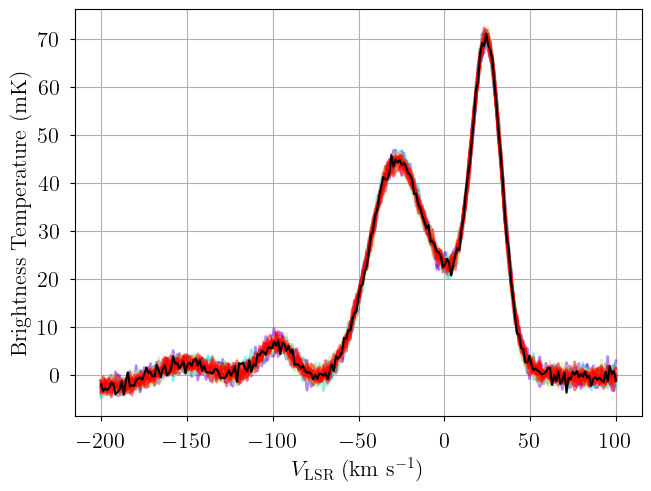

In [8]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(opt.best_model.data, posterior.posterior_predictive)